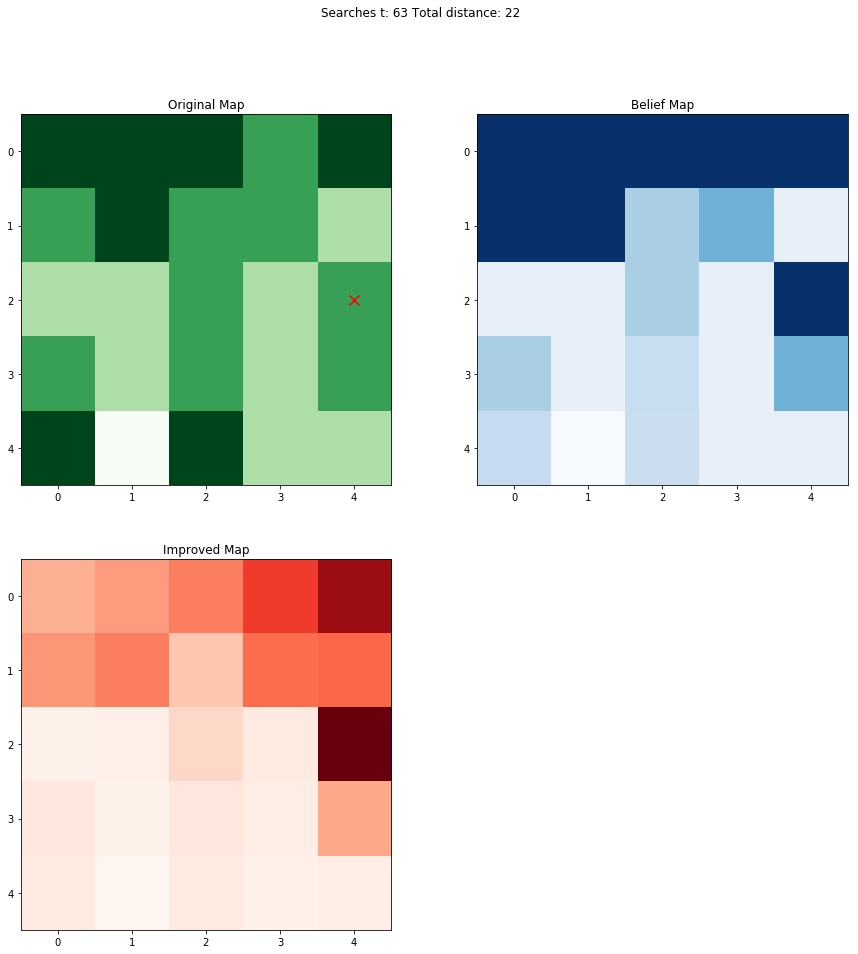

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import cm
import random
import matplotlib.gridspec as gridspec
import sys
import copy
import time


dim = 5

flatTerrainRate = 0.1
hillyTerrainRate = 0.3
forestedTerrainRate = 0.7
caveTerrainRate = 0.9

flat = 0 
hilly = 1
forested = 2
cave = 3

# Generates the terrain and values for the map
def generateMap(dim):
        map = np.zeros([dim, dim])
        for i in range(dim):
            for j in range(dim):
                p = np.random.rand()
                if p <= 0.2:
                    # Initialize Flat Terrain
                    map[i][j] = flat
                elif p > 0.2 and p <= 0.5:
                    # Initialize Hilly Terrain
                    map[i][j] = hilly
                elif p > 0.5 and p <= 0.8:
                    # Initialize Forested Terrain
                    map[i][j] = forested
                else:
                    # Initialize Cave Terrain
                    map[i][j] = cave
        return map

# Generates the coordinates of the target marker and agent marker randomly
def generateMarker(dim):
    i = np.random.randint(dim)
    j = np.random.randint(dim)
    return [i, j]

# Generates the initial probability state for the beliefState 
def generateInitialState(dim):
    initialProb = 1/(dim*dim)
    probState = np.zeros([dim, dim])
    for i in range(dim):
        for j in range(dim):
            probState[i][j] = initialProb
    return probState

# State where agent is at target coordinate and tries to find the target
def targetState(t, map, agent, target):
    foundVal = np.random.rand()
    targeti = agent[0]
    targetj = agent[1]

    # If the randomly generated number is greater than the rate of the target terrain then the target is found
    if map[targeti][targetj] == flat :
        if foundVal > flatTerrainRate :
            return 1
    elif map[targeti][targetj] == hilly :
       if foundVal > hillyTerrainRate :
            return 1
    elif map[targeti][targetj] == forested :
       if foundVal > forestedTerrainRate :
            return 1
    else :
        if foundVal > caveTerrainRate :
            return 1
    
    # if not found we continue with update
    return
        

# Updates our current belief state at time t
def updateBeliefState(dim, beliefState, t, map, agent, target, finalDist, improvedState):
    agenti = agent[0]
    agentj = agent[1]

    # if agent is at target cell go into the target state to find the target
    if (agent[0] == target[0] and agent[1] == target[1]):
        check = targetState(t, map, agent, target)

        # if check successful return 0 and print figure
        if (check == 1) :
            printGrid(map, target, beliefState, t, finalDist, improvedState)
            return 0

    beliefState[agenti][agentj]
    
# Calculates the new belief state for the current cell using P(Target in Celli|Observationst∧Failure in Cellj)
    if map[agenti][agentj] == flat :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * flatTerrainRate
    elif map[agenti][agentj] == hilly :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * hillyTerrainRate
    elif map[agenti][agentj] == forested :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * forestedTerrainRate
    else :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * caveTerrainRate
# Take total Of belief matrix
    newTotal = np.sum(beliefState)

# Normalize the belief matrix
    beliefState = beliefState/newTotal
    return beliefState
   

# returns manhattan distance between two coordinates
def manhattanDistance(x1, y1, x2, y2):
        return abs(x1-x2) + abs(y1-y2)

# Searches grid for next position that agent shall search based on manhattan distance and highest belief probability. The one with the greatest probability and lowest distance will be chosen
def searchNext(t, dim, improvedState, agent):
    maxVal = 0
    mXCoor = 0
    mYCoor = 0
    dist = 0
    smallestDist = dim * dim
    for searchi in range(dim):
        for searchj in range(dim):
            if improvedState[searchi][searchj] > maxVal:
                maxVal = improvedState[searchi][searchj]
                mXCoor = searchi
                mYCoor = searchj
                smallestDist = dim * dim
            elif improvedState[searchi][searchj] == maxVal:
                manDist = manhattanDistance(searchi, searchj, agent[0], agent[1])
                if manDist < smallestDist:
                    smallestDist = manDist
                    maxVal = improvedState[searchi][searchj]
                    mXCoor = searchi
                    mYCoor = searchj
    dist += manhattanDistance(agent[0], agent[1], mXCoor, mYCoor)
    agent[0] = mXCoor
    agent[1] = mYCoor
    return dist

# implements the strategy for our improved agent where we utilize our utility function to choose the highest probability after calculating the beliefState divided by the cost to search based on the fail rate and manhattan distance
def improvedStrat(dim, beliefState, map, improvedState, agent):
    dMatrix = initializeDistanceState(dim, agent[0], agent[1])
    for i in range(dim):
        for j in range(dim):
            if map[i][j] == flat :
                terrainRate = flatTerrainRate
            elif map[i][j] == hilly :
                terrainRate = hillyTerrainRate
            elif map[i][j] == forested :
                terrainRate = forestedTerrainRate
            else :
                terrainRate = caveTerrainRate
            improvedState[i][j] = beliefState[i][j]/(dMatrix[i][j] + terrainRate)
    return improvedState

# Runs the search for the agent using rule 1
def executeImprovedAgent():
    t = 0
    finalDist = 0
    map = generateMap(dim)
    target = generateMarker(dim)
    agent = generateMarker(dim)
    beliefState = generateInitialState(dim) 
    improvedState = generateInitialState(dim)
    while True:
        t = t + 1
        beliefState = updateBeliefState(dim, beliefState, t, map, agent, target, finalDist, improvedState)
        if isinstance(beliefState,int):
            return
        improvedState = improvedStrat(dim, beliefState, map, improvedState, agent)
        distOfSearch = searchNext(t, dim, improvedState, agent)
        finalDist +=distOfSearch
    return

# Prints the visualization of the originalmap, belief state, and displays the amount of searches and total distance
def printGrid(map, target, beliefState, t, finalDist, improvedState):
    totalPerformance = t + finalDist
    grid = gridspec.GridSpec(ncols=2, nrows=2)
    fig = plt.figure(figsize=(15,15))
    ogMap = fig.add_subplot(grid[0, 0])
    beliefMap = fig.add_subplot(grid[0,1])
    improvedMap = fig.add_subplot(grid[1,0])
    Image3 = improvedMap.imshow(improvedState, cmap = cm.get_cmap('Reds'))
    Image2 = beliefMap.imshow(beliefState, cmap = cm.get_cmap('Blues'))
    Image = ogMap.imshow(map, cmap = cm.get_cmap('Greens', 4))
    improvedMap.set_title("Improved Map")
    beliefMap.set_title("Belief Map")
    ogMap.set_title("Original Map")
    fig.suptitle('Searches t: {} Total distance: {} Total Performance: {}'.format(t, finalDist, totalPerformance))
    ogMap.scatter(target[1], target[0], s=100, c='red', marker='x')
    return 

# Generates distance for all cells based of the agents current location
def initializeDistanceState(dim, x1, y1):
    distanceState = np.zeros([dim, dim])
    for x2 in range(dim):
        for y2 in range(dim):
            distanceState[x2][y2] = manhattanDistance(x1, y1, x2, y2)
    return distanceState

executeImprovedAgent()
